In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# plt.style.use('dark_background')
import warnings
warnings.filterwarnings('ignore') 

start = time.perf_counter()

In [2]:
df = pd.read_csv('earl694412-infinite-matchhistory.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577 entries, 0 to 576
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            577 non-null    object 
 1   Player          577 non-null    object 
 2   MatchId         577 non-null    object 
 3   Map             577 non-null    object 
 4   Category        577 non-null    object 
 5   Playlist        577 non-null    object 
 6   Input           577 non-null    object 
 7   Queue           577 non-null    object 
 8   Csr             577 non-null    int64  
 9   Mmr             1 non-null      float64
 10  Outcome         577 non-null    object 
 11  Accuracy        577 non-null    float64
 12  DamageDone      577 non-null    int64  
 13  DamageTaken     577 non-null    int64  
 14  ShotsFired      577 non-null    int64  
 15  ShotsLanded     577 non-null    int64  
 16  ShotsMissed     577 non-null    int64  
 17  KD              577 non-null    flo

In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df['LengthMinutes'] = df['LengthSeconds'] / 60
df['DamageRatio'] = df['DamageDone'] / df['DamageTaken']
df['Kills/10Min'] = (df['Kills'] / df['LengthMinutes']) * 10
df['Deaths/10Min'] = (df['Deaths'] / df['LengthMinutes']) * 10
df['Assists/10Min'] = (df['Assists'] / df['LengthMinutes']) * 10
df['Dmg/10Min'] = (df['DamageDone'] / df['LengthMinutes']) * 10
df['DmgT/10Min'] = (df['DamageTaken'] / df['LengthMinutes']) * 10
df['ExcessKills'] = df['Kills'] - df['ExpectedKills']
df['ExcessDeaths'] = df['ExpectedDeaths'] - df['Deaths']
df['ExcessKD'] = df['KD'] - round((df['ExpectedKills'] / df['ExpectedDeaths']),2)
df['LifetimeKD'] = df['Kills'].cumsum() / df['Deaths'].cumsum()
df['LifetimeDmgRatio'] = df['DamageDone'].cumsum() / df['DamageTaken'].cumsum()
df['LifetimeAcc'] = df['ShotsLanded'].cumsum() / df['ShotsFired'].cumsum() * 100

df = df.drop(['Player', 'MatchId', 'Input', 'Queue', 'Mmr'],axis=1)
dfr = df[df['Date']> '2023-01-01']
dfr = dfr[dfr['Playlist'] == 'Ranked Arena']
dfr['Csr'] = dfr['Csr'].replace(0, method='ffill')
dfr = dfr[dfr['Outcome'] != 'Draw']
dfr = dfr[dfr['Outcome'] != 'Left']
dfr['Outcome'] = dfr['Outcome'].map({'Win': 1, 'Loss': 0})
dfr['LifetimeWinRate'] = (dfr['Outcome'].cumsum() / 
                          (dfr['Outcome'].cumsum() + 
                           dfr['Outcome'].eq(0).cumsum())).fillna(0)
dfr = dfr.drop('Playlist', axis=1).reset_index()
dfr.loc[:4, 'Csr'] = 808
dfr.to_csv('df.csv')
dfr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 39 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   index             366 non-null    int64         
 1   Date              366 non-null    datetime64[ns]
 2   Map               366 non-null    object        
 3   Category          366 non-null    object        
 4   Csr               366 non-null    int64         
 5   Outcome           366 non-null    int64         
 6   Accuracy          366 non-null    float64       
 7   DamageDone        366 non-null    int64         
 8   DamageTaken       366 non-null    int64         
 9   ShotsFired        366 non-null    int64         
 10  ShotsLanded       366 non-null    int64         
 11  ShotsMissed       366 non-null    int64         
 12  KD                366 non-null    float64       
 13  KDA               366 non-null    float64       
 14  Kills             366 non-

In [4]:
dfr.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
index,366.0,359.098361,125.574891,140.000000,257.250000,357.500000,465.750000,576.000000
Csr,366.0,953.442623,53.381601,790.000000,933.000000,958.000000,991.000000,1058.000000
Outcome,366.0,0.532787,0.499607,0.000000,0.000000,1.000000,1.000000,1.000000
Accuracy,366.0,51.939317,5.590050,24.390000,48.685000,52.335000,54.867500,80.560000
DamageDone,366.0,5090.010929,1847.617908,347.000000,3781.250000,4748.000000,6315.750000,12673.000000
DamageTaken,366.0,4396.199454,1566.490079,276.000000,3380.500000,4150.500000,5335.000000,9962.000000
ShotsFired,366.0,228.789617,78.823903,16.000000,178.250000,218.000000,286.750000,468.000000
ShotsLanded,366.0,118.702186,42.361734,4.000000,92.000000,111.000000,147.750000,281.000000
ShotsMissed,366.0,110.087432,39.780810,7.000000,83.250000,106.000000,136.000000,261.000000
KD,366.0,1.244508,0.676583,0.000000,0.860000,1.130000,1.430000,6.000000


In [5]:
dfr.Kills.sum()

5266

In [6]:
# dfr.hist(bins=15, figsize=(18, 14))
# plt.tight_layout()
# plt.show()

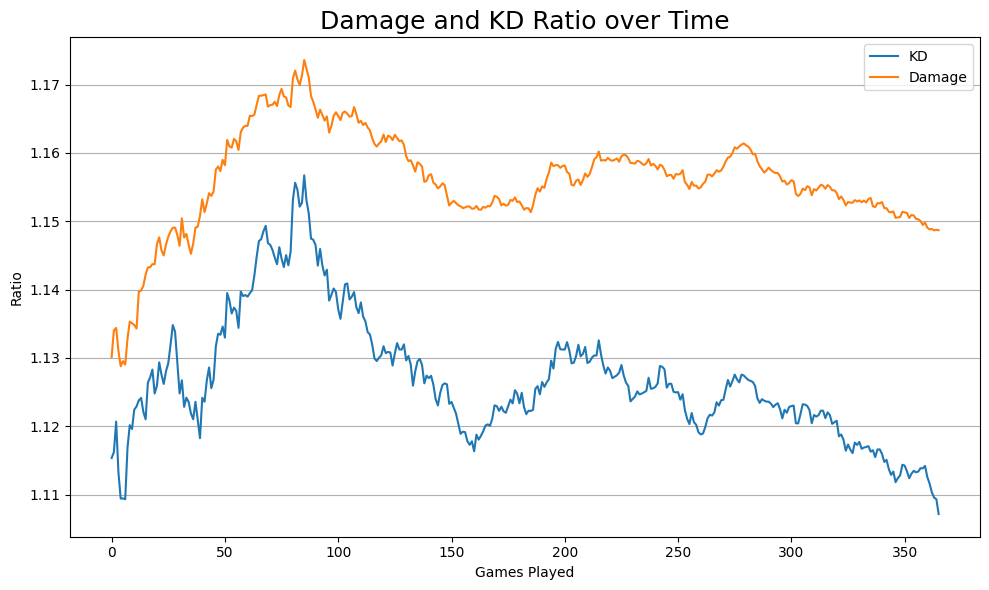

In [7]:
plt.figure(figsize=(10,6))
plt.plot(dfr['LifetimeKD'], label='KD' )
plt.plot(dfr['LifetimeDmgRatio'], label='Damage')
plt.title('Damage and KD Ratio over Time', fontsize=18)
plt.xlabel('Games Played')
plt.ylabel('Ratio')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig('Plots/DamKDRatios.png', dpi=300)
plt.show()

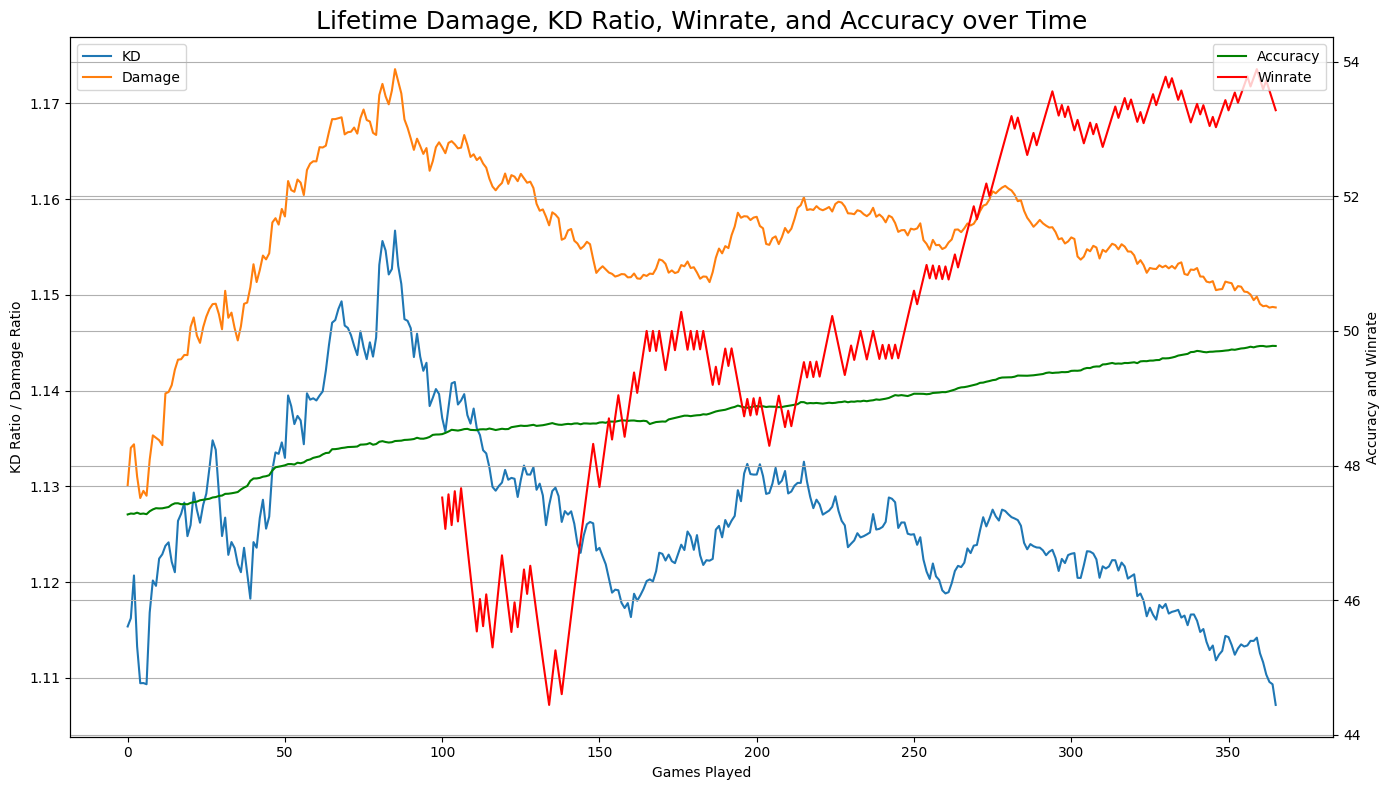

In [38]:
# Smooth the LifetimeWinRate using a 10-game moving average
# dfr['SmoothedAccuracy'] = dfr['Accuracy'].rolling(window=25).mean()

plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeKD'], label='KD' )
ax1.plot(dfr['LifetimeDmgRatio'], label='Damage')
ax2.plot(dfr['LifetimeAcc'], color='green', label='Accuracy')
ax2.plot(dfr['LifetimeWinRate'][100:]*100, color='red', label='Winrate')
ax1.set_title('Lifetime Damage, KD Ratio, Winrate, and Accuracy over Time', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('KD Ratio / Damage Ratio')
ax2.set_ylabel('Accuracy and Winrate')
# max_y_value = df['LifetimeAcc'].max()
ax1.yaxis.grid(True)
ax2.yaxis.grid(True)
# ax2.set_yticks(np.arange(47, max_y_value, 0.5))
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
# plt.savefig('Plots/DamKDRatiosAcc.png', dpi=300)
plt.show()

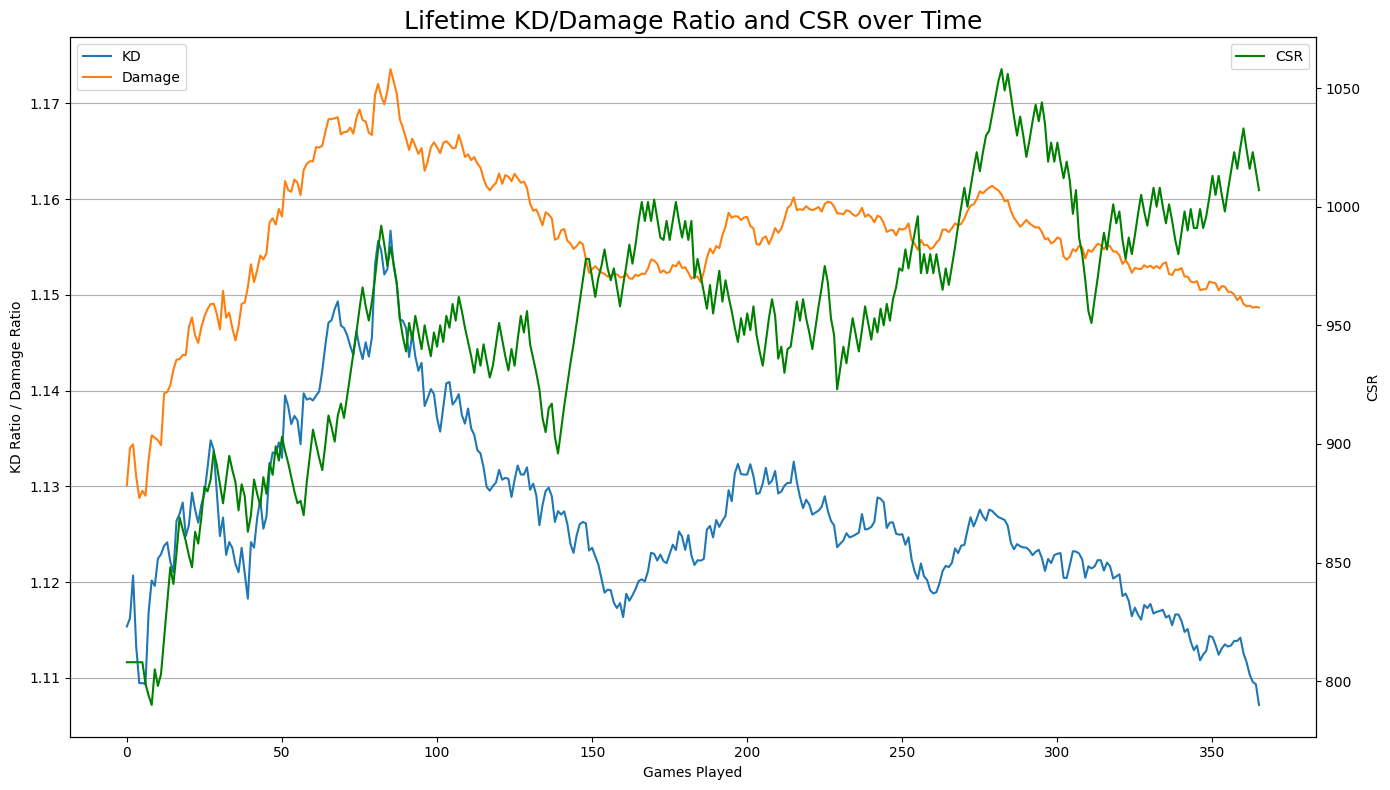

In [9]:
# Smooth the LifetimeWinRate using a 10-game moving average
# dfr['SmoothedAccuracy'] = dfr['Accuracy'].rolling(window=25).mean()

plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeKD'], label='KD' )
ax1.plot(dfr['LifetimeDmgRatio'], label='Damage')
ax2.plot(dfr['Csr'], color='green', label='CSR')
ax1.set_title('Lifetime KD/Damage Ratio and CSR over Time', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('KD Ratio / Damage Ratio')
ax2.set_ylabel('CSR')
# max_y_value = df['LifetimeAcc'].max()
ax1.yaxis.grid(True)
# ax2.set_yticks(np.arange(47, max_y_value, 0.5))
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
# plt.savefig('Plots/DamKDRatiosAcc.png', dpi=300)
plt.show()

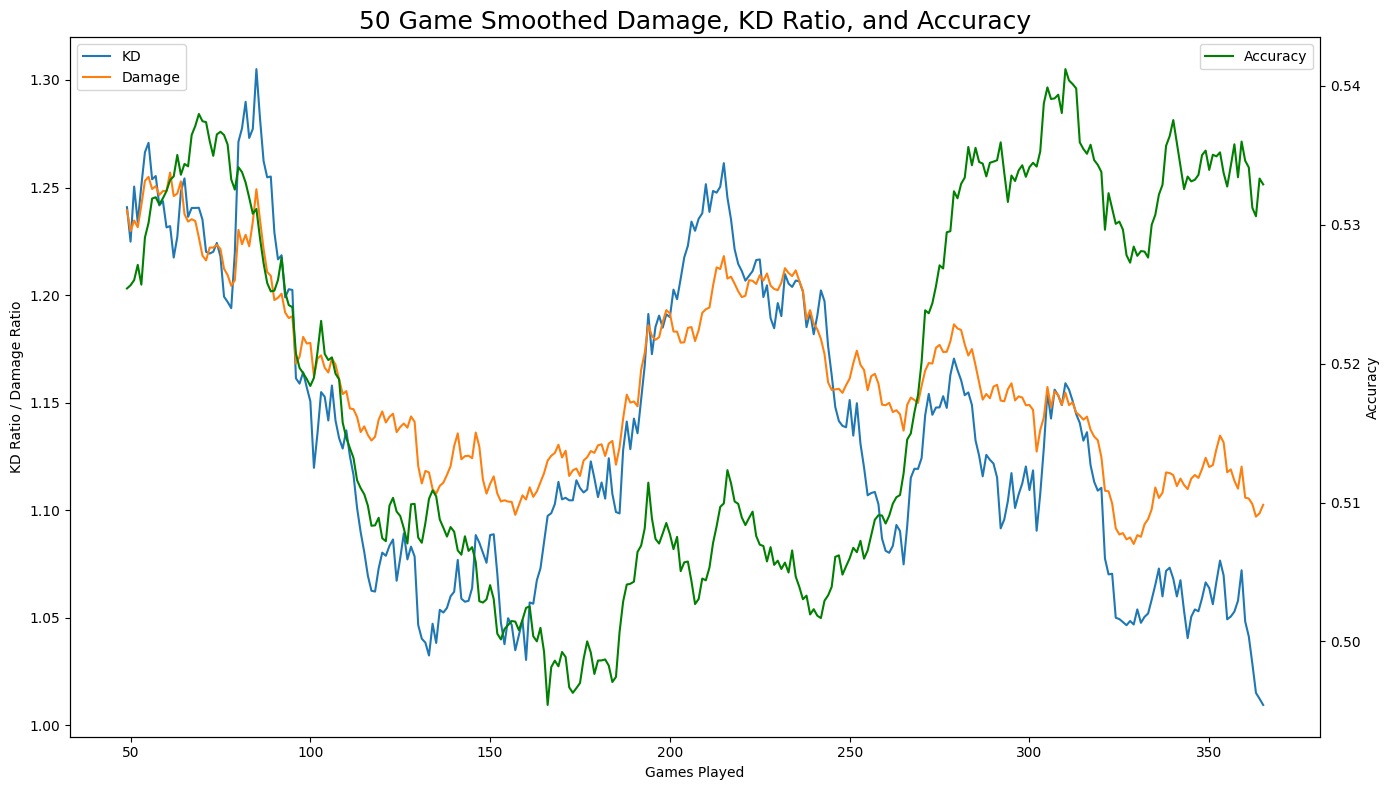

In [10]:
# Smooth the LifetimeWinRate using a 10-game moving average
# Set roll to ** game moving average
roll = 50
dfr['SmoothedAccuracy'] = dfr['ShotsLanded'].rolling(window=roll).sum() / dfr['ShotsFired'].rolling(window=roll).sum()
dfr['SmoothedDmgRatio'] = dfr['DamageDone'].rolling(window=roll).sum() / dfr['DamageTaken'].rolling(window=roll).sum()
dfr['SmoothedKD'] = dfr['Kills'].rolling(window=roll).sum() / dfr['Deaths'].rolling(window=roll).sum()


plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['SmoothedKD'], label='KD' )
ax1.plot(dfr['SmoothedDmgRatio'], label='Damage')
ax2.plot(dfr['SmoothedAccuracy'], color='green', label='Accuracy')
ax1.set_title(f'{roll} Game Smoothed Damage, KD Ratio, and Accuracy', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('KD Ratio / Damage Ratio')
ax2.set_ylabel('Accuracy')
max_y_value = df['Accuracy'].max()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.savefig('Plots/DamKDRatiosAccSmooth.png', dpi=300)
plt.show()

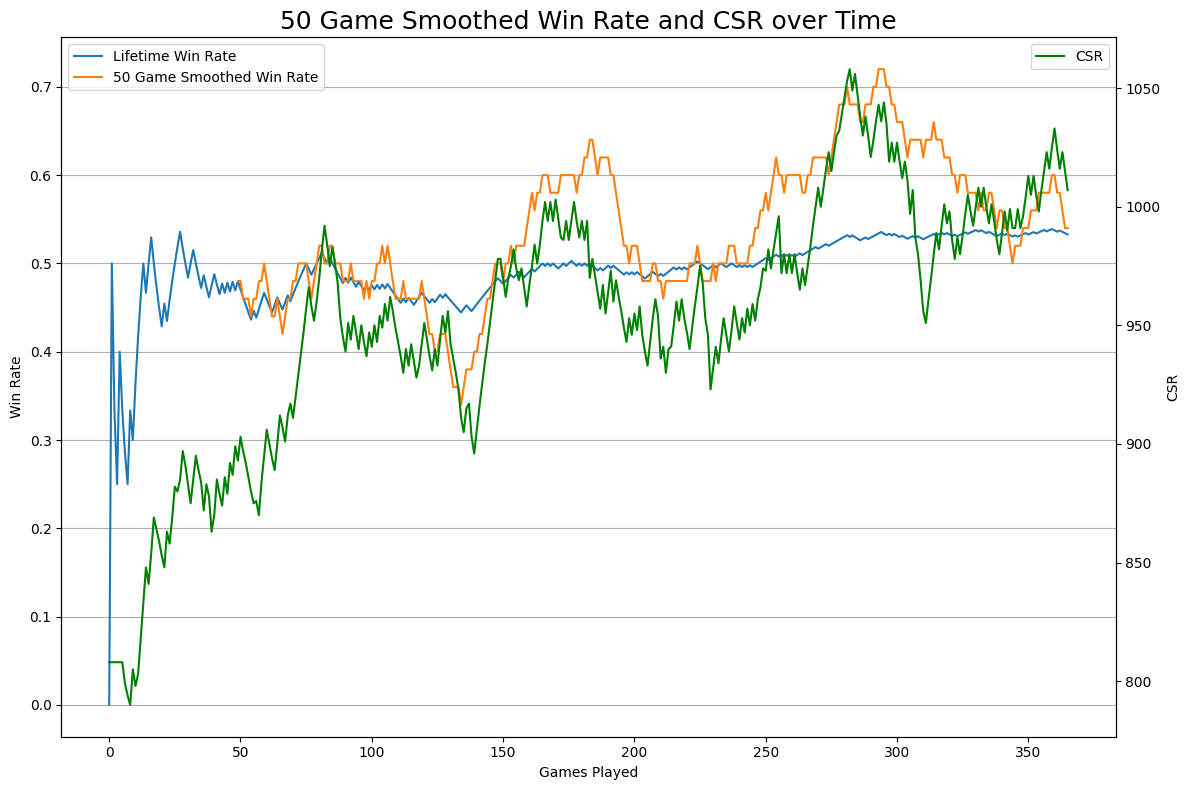

In [11]:
# Smooth the LifetimeWinRate using a 10-game moving average
# dfr['SmoothedWinRate'] = dfr['LifetimeWinRate'].rolling(window=15).mean()
roll = 50
dfr['SmoothedWinRate'] = dfr['Outcome'].rolling(window=roll).sum() / dfr['Outcome'].rolling(window=roll).count()

plt.figure(figsize=(12,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeWinRate'], label='Lifetime Win Rate' )
ax1.plot(dfr['SmoothedWinRate'], label=(f'{roll} Game Smoothed Win Rate'))
ax2.plot(dfr['Csr'], color='green', label='CSR')
ax1.set_title(f'{roll} Game Smoothed Win Rate and CSR over Time', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('Win Rate')
ax2.set_ylabel('CSR')
ax1.yaxis.grid(True)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.savefig('Plots/WinRateCSR.png', dpi=300)
plt.show()

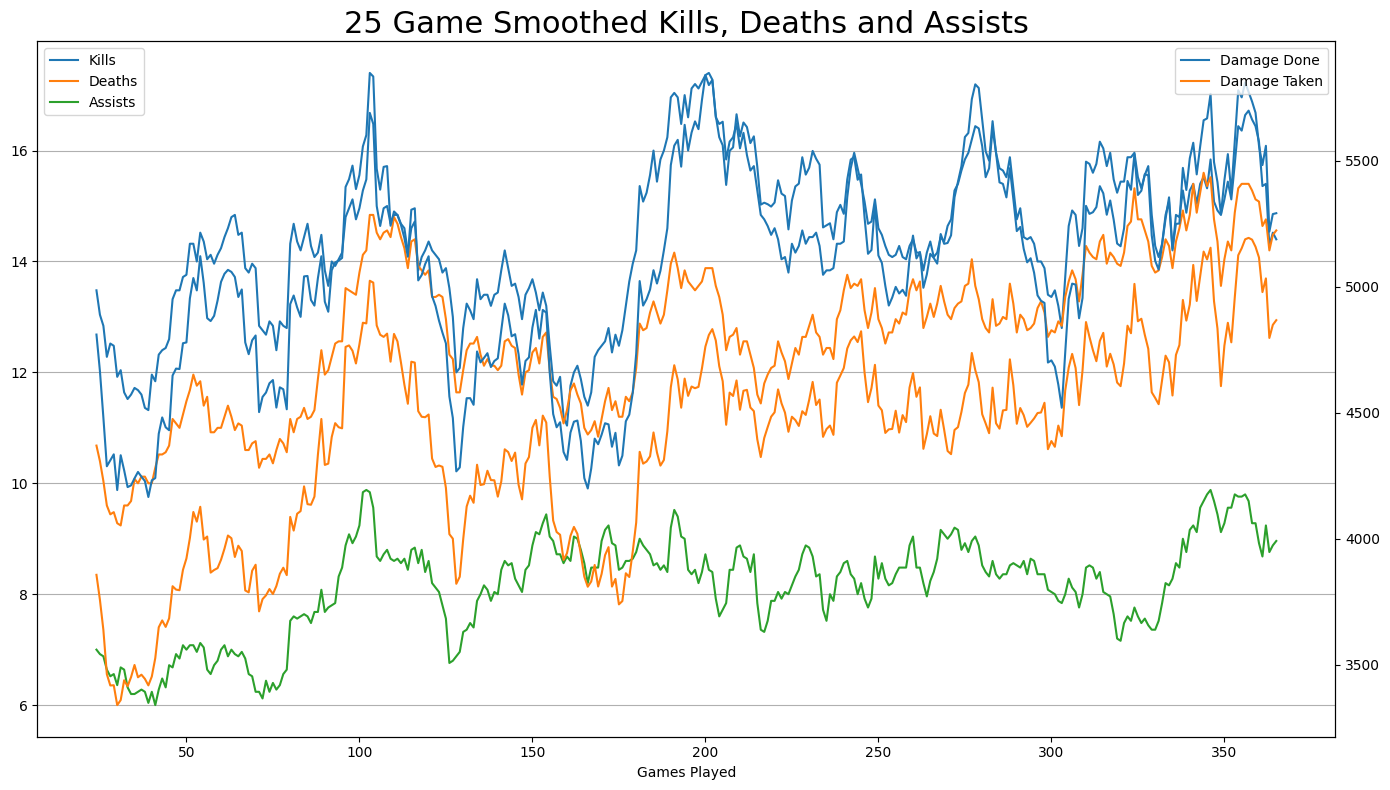

In [12]:
# Smooth the LifetimeWinRate using a 10-game moving average
# Set roll to ** game moving average
roll = 25
dfr['SmoothedKills'] = dfr['Kills'].rolling(window=roll).mean() 
dfr['SmoothedDeaths'] = dfr['Deaths'].rolling(window=roll).mean() 
dfr['SmoothedAssists'] = dfr['Assists'].rolling(window=roll).mean()
dfr['SmoothedDmg'] = dfr['DamageDone'].rolling(window=roll).mean()
dfr['SmoothedDmgT'] = dfr['DamageTaken'].rolling(window=roll).mean()


plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = plt.twinx(ax1)
ax1.plot(dfr['SmoothedKills'], label='Kills' )
ax1.plot(dfr['SmoothedDeaths'], label='Deaths')
ax1.plot(dfr['SmoothedAssists'], label='Assists')
ax2.plot(dfr['SmoothedDmg'], label='Damage Done')
ax2.plot(dfr['SmoothedDmgT'], label='Damage Taken')
ax1.set_title(f'{roll} Game Smoothed Kills, Deaths and Assists', fontsize=22)
ax1.set_xlabel('Games Played')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax2.set_facecolor('red')


ax1.yaxis.grid(True)
plt.tight_layout()
plt.savefig('Plots/KDASmooth.png', dpi=300)
plt.show()

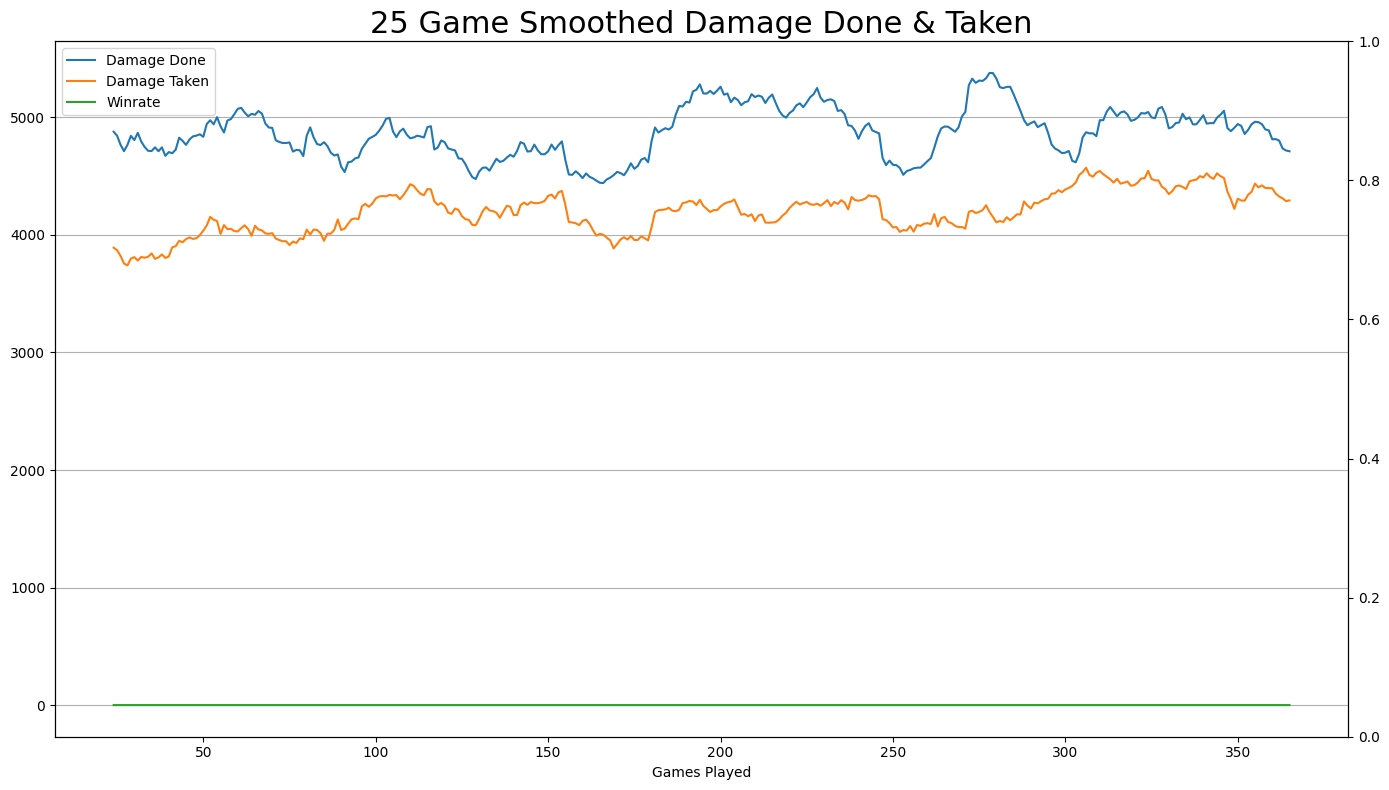

,index,Date,Map,Category,Csr,Outcome,Accuracy,DamageDone,DamageTaken,ShotsFired,...,LifetimeWinRate,SmoothedAccuracy,SmoothedDmgRatio,SmoothedKD,SmoothedWinRate,SmoothedKills,SmoothedDeaths,SmoothedAssists,SmoothedDmg,SmoothedDmgT
0,140,2023-10-19 19:49:41,Solitude,King of the Hill,808,0,52.31,7146,4957,325,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,141,2023-10-19 20:06:10,Solitude,Strongholds,808,1,50.49,7974,5281,309,...,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,142,2023-10-19 20:25:03,Recharge,King of the Hill,808,0,46.36,6889,5906,343,...,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,143,2023-10-19 20:42:40,Streets,Extraction,808,0,53.61,3854,4960,194,...,0.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,144,2023-10-19 20:55:21,Argyle,CTF 3 Captures,808,1,41.56,2769,3501,231,...,0.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Smooth the LifetimeWinRate using a 10-game moving average
# Set roll to ** game moving average
roll = 25
dfr['SmoothedDmg'] = dfr['Dmg/10Min'].rolling(window=roll).mean()
dfr['SmoothedDmgT'] = dfr['DmgT/10Min'].rolling(window=roll).mean()
dfr['SmoothedWinRate'] = dfr['Outcome'].rolling(window=roll).sum() / dfr['Outcome'].rolling(window=roll).count()

plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['SmoothedDmg'], label='Damage Done')
ax1.plot(dfr['SmoothedDmgT'], label='Damage Taken')
ax1.plot(dfr['SmoothedWinRate'], label='Winrate')
ax1.set_title(f'{roll} Game Smoothed Damage Done & Taken', fontsize=22)
ax1.set_xlabel('Games Played')
ax1.legend(loc='upper left')
ax1.yaxis.grid(True)
plt.tight_layout()
plt.savefig('Plots/KDASmooth.png', dpi=300)
plt.show()

dfr.head()

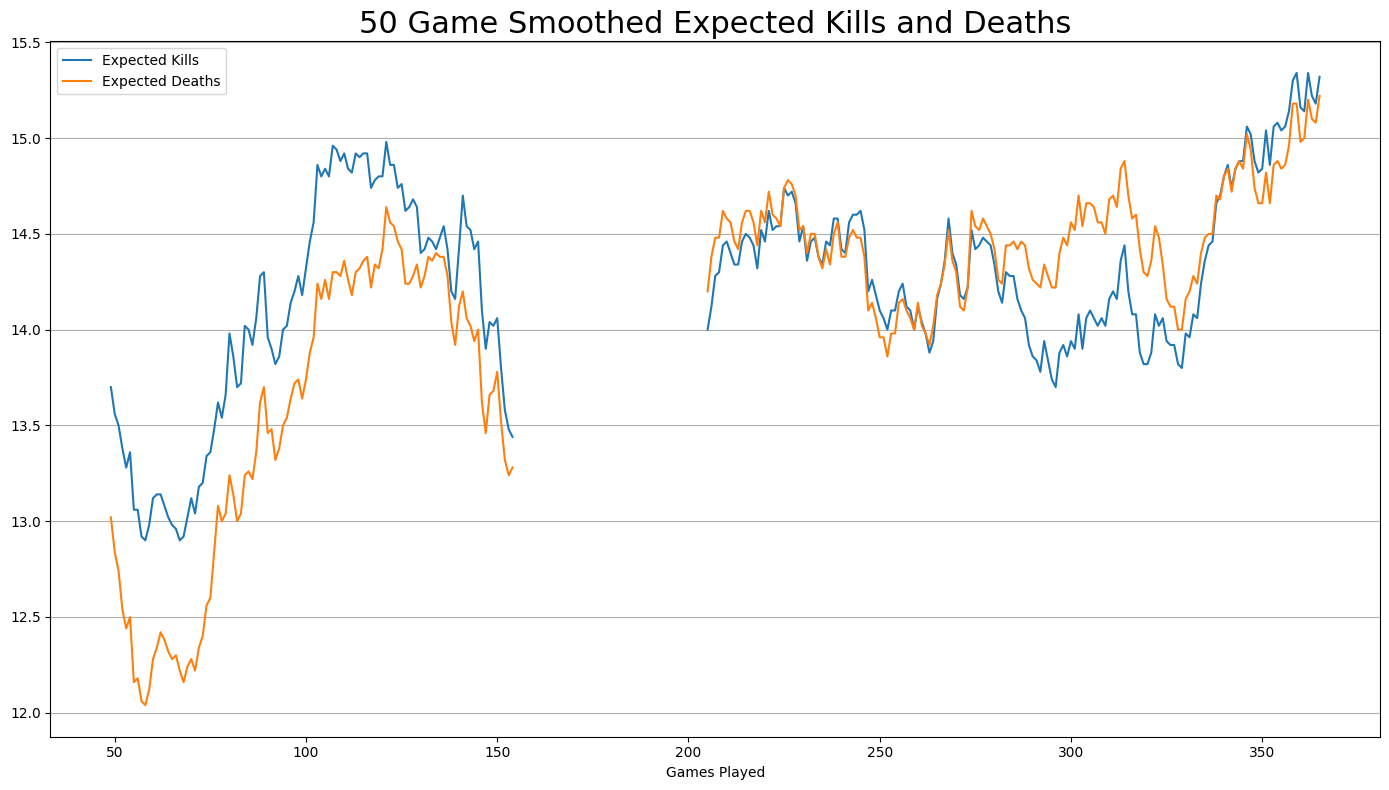

In [14]:
# Smooth the LifetimeWinRate using a 10-game moving average
# Set roll to ** game moving average
roll = 50
dfr['SmoothedExKills'] = dfr['ExpectedKills'].rolling(window=roll).mean()
dfr['SmoothedExDeaths'] = dfr['ExpectedDeaths'].rolling(window=roll).mean()

plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax1.plot(dfr['SmoothedExKills'], label='Expected Kills')
ax1.plot(dfr['SmoothedExDeaths'], label='Expected Deaths')
ax1.set_title(f'{roll} Game Smoothed Expected Kills and Deaths', fontsize=22)
ax1.set_xlabel('Games Played')
ax1.legend(loc='upper left')
ax1.yaxis.grid(True)
plt.tight_layout()
plt.savefig('Plots/ExKDSmooth.png', dpi=300)
plt.show()

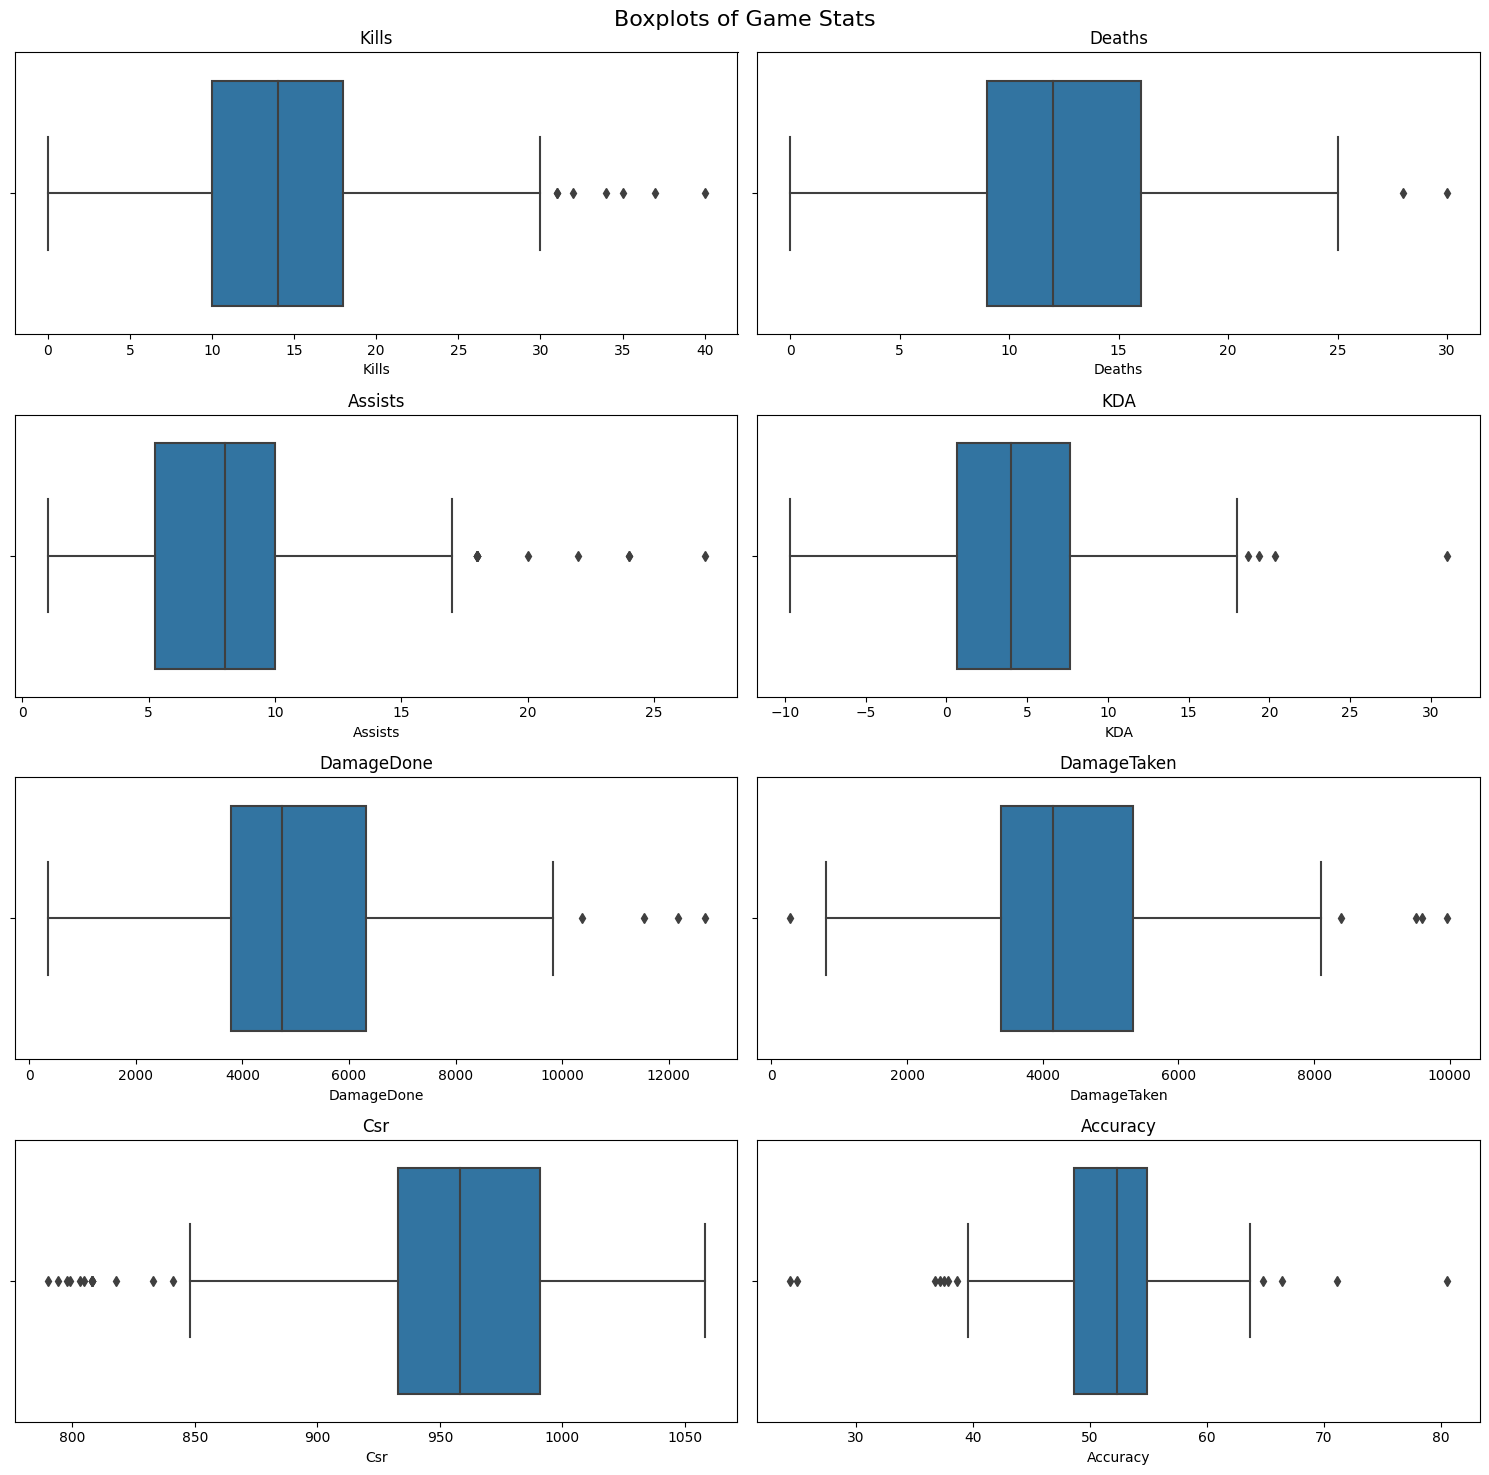

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
columns = ['Kills', 'Deaths', 'Assists', 'KDA', 'DamageDone', 'DamageTaken',
            'Csr', 'Accuracy']

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))

# Flatten the axes for easier iteration
axes = axes.flatten()

# Plot each column in a separate boxplot
for i, column in enumerate(columns):
    sns.boxplot(x=dfr[column], ax=axes[i])
    axes[i].set_title(column)

# Adjust layout
plt.suptitle('Boxplots of Game Stats', fontsize=16)
plt.tight_layout()
plt.savefig('Plots/Boxplots.png', dpi=300)
plt.show()


In [16]:
mod = 20

# dfmod = dfr.loc[dfr['Deaths'] < mod, 
#                 ['Kills', 'Deaths', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome']
#                 ].sort_values('DamageDone', ascending=False)

# Column Choice <>
# dfmod = dfr.loc[dfr['Deaths'] < mod]

# Last * Games
dfmod = dfr.tail(mod)

# print(dfmod.head())
print(f'Overall KD: {round(dfmod["Kills"].sum() / dfmod["Deaths"].sum(),2)}')
print(f"Accuracy: {round(dfmod['ShotsLanded'].sum() / dfmod['ShotsFired'].sum()*100,2)}")
print(f"Damage Ratio: {round(dfmod['DamageDone'].sum() / dfmod['DamageTaken'].sum(),2)}")
print(f"Win-Loss: {(dfmod['Outcome']==1).sum()}-{(dfmod['Outcome']==0).sum()}")
print(f"Max CSR: {dfmod['Csr'].max()}")

Overall KD: 1.01
Accuracy: 52.91
Damage Ratio: 1.1
Win-Loss: 11-9
Max CSR: 1033


In [17]:
dfw = dfr.loc[dfr['Outcome'] == 1, 
                ['Kills', 'Deaths', 'Assists', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome', 'ShotsFired', 'ShotsLanded']
                ].sort_values('Kills', ascending=False)

dfl = dfr.loc[dfr['Outcome'] == 0, 
                ['Kills', 'Deaths', 'Assists', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome', 'ShotsFired', 'ShotsLanded']
                ].sort_values('Kills', ascending=False)

print('Overall')
print(f'Overall KD: {round(dfr["Kills"].sum() / dfr["Deaths"].sum(),2)}')
print(f"Average Kills: {round(dfr['Kills'].mean(),2)}")
print(f"Average Deaths: {round(dfr['Deaths'].mean(),2)}")
print(f"Average Assists: {round(dfr['Assists'].mean(),2)}")
print(f"Average Accuracy: {round(dfr['ShotsLanded'].sum() / dfr['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfr['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfr['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfr['DamageDone'].sum() / dfr['DamageTaken'].sum(),2)}")
print(f"Win-Loss: {(dfr['Outcome']==1).sum()}-{(dfr['Outcome']==0).sum()}")
print('----------------------------')
print('Wins')
print(f'Overall KD: {round(dfw["Kills"].sum() / dfw["Deaths"].sum(),2)}')
print(f"Average Kills: {round(dfw['Kills'].mean(),2)}")
print(f"Average Deaths: {round(dfw['Deaths'].mean(),2)}")
print(f"Average Assists: {round(dfw['Assists'].mean(),2)}")
print(f"Average Accuracy: {round(dfw['ShotsLanded'].sum() / dfw['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfw['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfw['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfw['DamageDone'].sum() / dfw['DamageTaken'].sum(),2)}")
print(f"Wins: {(dfw['Outcome']==1).sum()}")
print('----------------------------')
print('Losses')
print(f'Overall KD: {round(dfl["Kills"].sum() / dfl["Deaths"].sum(),2)}')
print(f"Average Kills: {round(dfl['Kills'].mean(),2)}")
print(f"Average Deaths: {round(dfl['Deaths'].mean(),2)}")
print(f"Average Assists: {round(dfl['Assists'].mean(),2)}")
print(f"Average Accuracy: {round(dfl['ShotsLanded'].sum() / dfl['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfl['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfl['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfl['DamageDone'].sum() / dfl['DamageTaken'].sum(),2)}")
print(f"Losses: {(dfl['Outcome']==0).sum()}")

Overall
Overall KD: 1.13
Average Kills: 14.39
Average Deaths: 12.76
Average Assists: 8.17
Average Accuracy: 51.88
Average Damage Done: 5090
Average Damage Taken: 4396
Damage Ratio: 1.16
Win-Loss: 195-171
----------------------------
Wins
Overall KD: 1.26
Average Kills: 14.02
Average Deaths: 11.12
Average Assists: 8.34
Average Accuracy: 52.14
Average Damage Done: 4872
Average Damage Taken: 4022
Damage Ratio: 1.21
Wins: 195
----------------------------
Losses
Overall KD: 1.01
Average Kills: 14.81
Average Deaths: 14.63
Average Assists: 7.96
Average Accuracy: 51.61
Average Damage Done: 5338
Average Damage Taken: 4823
Damage Ratio: 1.11
Losses: 171


In [18]:
mapCatKD = dfr.pivot_table(index=['Category', 'Map'], 
                        values=['Kills', 'Deaths', 'Assists', 'Accuracy', 'DamageRatio', 'Outcome'], 
                        aggfunc='mean')

avg_k = dfr['Kills'].mean()
avg_d = dfr['Deaths'].mean()
avg_a = dfr['Assists'].mean()
avg_kd= round(dfr['Kills'].sum() / dfr['Deaths'].sum(),2)

mapCatKD['ExKills'] = mapCatKD['Kills'] - avg_k
mapCatKD['ExDeaths'] = mapCatKD['Deaths'] - avg_d
mapCatKD['ExAssists'] = mapCatKD['Assists'] - avg_a

mapCatKD['KD'] = mapCatKD['Kills'] / mapCatKD['Deaths']
mapCatKD['ExKD'] = mapCatKD['KD'] - avg_kd

desired_col_order = ['Kills','ExKills', 'Deaths', 'ExDeaths', 'Assists', 'ExAssists', 'KD', 'ExKD', 'Accuracy', 'DamageRatio', 'Outcome']

# Reindex the pivot table with the desired column order
mapCatKD = mapCatKD.reindex(desired_col_order, axis=1)
mapCatKD = mapCatKD.round(2)

mapCatKD.sort_values('Outcome', ascending=False)

Kills  ExKills  Deaths  ExDeaths  Assists  \
Category         Map                                                    
King of the Hill Live Fire  13.25    -1.14   13.19      0.43     6.38   
Slayer           Recharge    9.14    -5.25    9.14     -3.62     7.29   
                 Streets     9.00    -5.39    8.58     -4.18     7.00   
CTF 3 Captures   Forbidden  14.58     0.20    9.75     -3.01     5.50   
Extraction       Recharge   12.94    -1.45   10.31     -2.45     8.25   
Slayer           Aquarius   10.94    -3.45    9.94     -2.82     6.56   
Strongholds      Live Fire  16.07     1.68   13.73      0.97     6.53   
King of the Hill Recharge   18.65     4.26   16.80      4.04    12.20   
Extraction       Streets    13.41    -0.97   10.76     -2.00     7.55   
Oddball          Streets    17.48     3.09   15.78      3.02    11.04   
                 Live Fire  15.00     0.61   14.88      2.12    10.31   
Slayer           Solitude   10.71    -3.67   11.00     -1.76     6.57   
CTF 3 Captures   Argyle     13.50    -0.89   12.29     -0.47     6.50   
King of the Hill Solitude   20.50     6.11   13.90      1.14     9.20   
Strongholds      Recharge   14.31    -0.08   14.62      1.87     9.50   
Oddball          Recharge   15.21     0.83   13.79      1.03     9.00   
Slayer           Live Fire  10.07    -4.32    9.93     -2.83     5.36   
CTF 3 Captures   Empyrean   13.47    -0.92   13.59      0.83     8.06   
Extraction       Live Fire  12.80    -1.59   11.60     -1.16     7.00   
Strongholds      Solitude   19.92     5.54   16.62      3.86    10.69   
CTF              Aquarius   20.64     6.25   15.36      2.60     8.86   

                            ExAssists    KD  ExKD  Accuracy  DamageRatio  \
Category         Map                                                       
King of the Hill Live Fire      -1.79  1.00 -0.13     56.32         1.06   
Slayer           Recharge       -0.88  1.00 -0.13     48.53         1.09   
                 Streets        -1.17  1.05 -0.08     49.66         1.15   
CTF 3 Captures   Forbidden      -2.67  1.50  0.37     54.89         1.51   
Extraction       Recharge        0.08  1.25  0.12     52.30         1.31   
Slayer           Aquarius       -1.60  1.10 -0.03     51.36         1.18   
Strongholds      Live Fire      -1.63  1.17  0.04     52.19         1.13   
King of the Hill Recharge        4.03  1.11 -0.02     50.29         1.13   
Extraction       Streets        -0.61  1.25  0.12     54.72         1.23   
Oddball          Streets         2.88  1.11 -0.02     54.27         1.20   
                 Live Fire       2.15  1.01 -0.12     51.65         1.21   
Slayer           Solitude       -1.60  0.97 -0.16     50.47         1.10   
CTF 3 Captures   Argyle         -1.67  1.10 -0.03     49.27         1.19   
King of the Hill Solitude        1.03  1.47  0.34     52.48         1.31   
Strongholds      Recharge        1.33  0.98 -0.15     49.67         1.16   
Oddball          Recharge        0.83  1.10 -0.03     49.59         1.12   
Slayer           Live Fire      -2.81  1.01 -0.12     48.48         1.06   
CTF 3 Captures   Empyrean       -0.11  0.99 -0.14     50.42         1.13   
Extraction       Live Fire      -1.17  1.10 -0.03     55.75         1.18   
Strongholds      Solitude        2.53  1.20  0.07     52.64         1.20   
CTF              Aquarius        0.69  1.34  0.21     51.88         1.32   

                            Outcome  
Category         Map                 
King of the Hill Live Fire     0.75  
Slayer           Recharge      0.71  
                 Streets       0.67  
CTF 3 Captures   Forbidden     0.67  
Extraction       Recharge      0.62  
Slayer           Aquarius      0.62  
Strongholds      Live Fire     0.60  
King of the Hill Recharge      0.60  
Extraction       Streets       0.59  
Oddball          Streets       0.57  
                 Live Fire     0.56  
Slayer           Solitude      0.54  
CTF 3 Captures   Argyle        0.50  
King of the Hill Solitude    

In [19]:
mapKD = dfr.pivot_table(index='Map', 
                        values=['Kills', 'Deaths', 'Assists', 'Accuracy', 'KD', 'DamageRatio', 'Outcome'], 
                        aggfunc='mean')

desired_col_order = ['Kills', 'Deaths', 'KD', 'Assists', 'Accuracy', 'DamageRatio', 'Outcome']

# Reindex the pivot table with the desired column order
mapKD = mapKD.reindex(desired_col_order, axis=1)
mapKD = mapKD.round(2)

mapKD

,Kills,Deaths,KD,Assists,Accuracy,DamageRatio,Outcome
Map,,,,,,,
Aquarius,13.89,11.59,1.29,7.26,51.52,1.22,0.52
Argyle,13.50,12.29,1.15,6.50,49.27,1.19,0.50
Empyrean,13.47,13.59,1.09,8.06,50.42,1.13,0.41
Forbidden,14.58,9.75,1.84,5.50,54.89,1.51,0.67
Live Fire,13.50,12.74,1.21,7.17,52.97,1.13,0.55
Recharge,14.88,13.59,1.25,9.66,50.29,1.17,0.55
Solitude,15.98,13.73,1.23,8.66,51.67,1.17,0.45
Streets,14.05,12.16,1.21,8.70,53.61,1.20,0.59


In [20]:
catKD = dfr.pivot_table(index='Category', 
                        values=['Kills', 'Deaths', 'Accuracy', 'KD', 'DamageRatio', 'Outcome', 'Assists'], 
                        aggfunc='mean')

desired_col_order = ['Kills', 'Deaths', 'Assists', 'KD', 'Accuracy', 'DamageRatio', 'Outcome']

# Reindex the pivot table with the desired column order
catKD = catKD.reindex(desired_col_order, axis=1)
catKD = catKD.round(2)

catKD

,Kills,Deaths,Assists,KD,Accuracy,DamageRatio,Outcome
Category,,,,,,,
CTF,20.64,15.36,8.86,1.50,51.88,1.32,0.29
CTF 3 Captures,13.79,12.09,6.84,1.32,51.29,1.26,0.51
Extraction,13.13,10.85,7.60,1.36,54.33,1.24,0.55
King of the Hill,17.17,14.91,9.52,1.23,52.87,1.14,0.63
Oddball,16.13,14.98,10.28,1.19,52.24,1.18,0.53
Slayer,10.35,10.02,6.49,1.17,50.23,1.13,0.58
Strongholds,17.33,15.30,9.26,1.18,51.69,1.17,0.44


In [21]:
dfrc = dfr.groupby('Category').agg({'LengthMinutes': 'sum', 'Category': 'count'})
dfrc.rename(columns={'Category': 'Count'}, inplace=True)
dfrc['LengthHours'] = round(dfrc['LengthMinutes'] / 60,2)
dfrc['LengthMinutes'] = round(dfrc['LengthMinutes'],2)
dfrc['Length%'] = round(dfrc['LengthMinutes'] / dfrc['LengthMinutes'].sum() * 100,2)
dfrc['Count%'] = round(dfrc['Count'] / dfrc['Count'].sum() * 100,2)
dfrc['TimeMultiple'] = dfrc['Length%'] - dfrc['Count%']
dfrc.sort_values('Length%', ascending=False)

,LengthMinutes,Count,LengthHours,Length%,Count%,TimeMultiple
Category,,,,,,
Slayer,800.30,93,13.34,21.18,25.41,-4.23
Strongholds,674.72,57,11.25,17.86,15.57,2.29
Oddball,624.50,53,10.41,16.53,14.48,2.05
Extraction,529.10,60,8.82,14.00,16.39,-2.39
King of the Hill,499.42,46,8.32,13.22,12.57,0.65
CTF 3 Captures,465.50,43,7.76,12.32,11.75,0.57
CTF,184.40,14,3.07,4.88,3.83,1.05


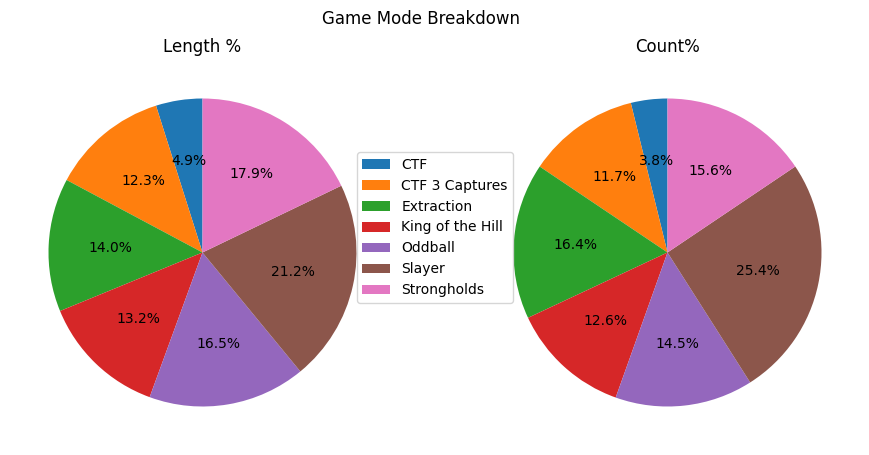

In [22]:
import matplotlib.pyplot as plt

labels = dfrc.index.get_level_values('Category').tolist()
sizes_length = dfrc['Length%'].tolist()
sizes_count = dfrc['Count%'].tolist()

fig, ax = plt.subplots(1, 2, figsize=(11, 5))  # Create a subplot with 1 row and 2 columns
ax[0].pie(sizes_length, labels=None, autopct='%1.1f%%', startangle=90)
ax[1].pie(sizes_count, labels=None, autopct='%1.1f%%', startangle=90)
fig.suptitle('Game Mode Breakdown')
ax[0].set(aspect="equal", title='Length %')
ax[1].set(aspect="equal", title='Count%')
fig.legend(labels, loc="center")

plt.show()

In [23]:
dfrc = dfr.groupby(['Category','Map']).agg({'Category': 'count', 'LengthMinutes': 'sum', 'Outcome': 'mean'})
dfrc.rename(columns={'Category': 'Count', 'LengthMinutes': 'LengthHours'}, inplace=True)
dfrc['LengthHours'] = round(dfrc['LengthHours']/60,2)
dfrc['Outcome'] = round(dfrc['Outcome'],2)
dfrc['Count%'] = round(dfrc['Count'] / dfrc['Count'].sum() * 100,2)
dfrc['Length%'] = round(dfrc['LengthHours'] / dfrc['LengthHours'].sum() * 100,2)
dfrc = dfrc.sort_values(['Length%'], ascending=False)
dfrc

,,Count,LengthHours,Outcome,Count%,Length%
Category,Map,,,,,
Strongholds,Solitude,26,5.48,0.35,7.10,8.70
Oddball,Streets,23,4.63,0.57,6.28,7.35
Slayer,Aquarius,32,4.59,0.62,8.74,7.29
Extraction,Streets,29,4.18,0.59,7.92,6.64
Slayer,Solitude,28,4.12,0.54,7.65,6.54
King of the Hill,Recharge,20,4.05,0.60,5.46,6.43
CTF 3 Captures,Empyrean,17,3.09,0.41,4.64,4.91
CTF,Aquarius,14,3.07,0.29,3.83,4.87
Oddball,Live Fire,16,3.01,0.56,4.37,4.78


In [24]:
dfrcc = dfr.groupby(['Category','Map']).agg({'Category': 'count',
                                             'Kills' : 'sum',
                                             'Deaths' : 'sum',
                                             'Assists' : 'sum',
                                             'DamageDone': 'sum',
                                             'DamageTaken': 'sum',
                                             'Outcome': 'mean',
                                             'LengthMinutes': 'sum',
                                             })
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Kills/10Min'] = dfrcc['Kills'] / dfrcc['LengthMinutes'] * 10
dfrcc['Deaths/10Min'] = dfrcc['Deaths'] / dfrcc['LengthMinutes'] * 10
dfrcc['Assists/10Min'] = dfrcc['Assists'] / dfrcc['LengthMinutes'] * 10
dfrcc['KDA/10Min'] = (dfrcc['Kills/10Min'] + (dfrcc['Assists/10Min'] / 3)) / dfrcc['Deaths/10Min'] 
dfrcc = round(dfrcc.sort_values(['Winrate', 'Kills'], ascending=False),2)
dfrcc

Count  Kills  Deaths  Assists  DamageDone  \
Category         Map                                                    
King of the Hill Live Fire     16    212     211      102       70068   
Slayer           Recharge       7     64      64       51       27933   
CTF 3 Captures   Forbidden     12    175     117       66       59534   
Slayer           Streets       12    108     103       84       42655   
                 Aquarius      32    350     318      210      134659   
Extraction       Recharge      16    207     165      132       71477   
King of the Hill Recharge      20    373     336      244      128767   
Strongholds      Live Fire     15    241     206       98       82304   
Extraction       Streets       29    389     312      219      128119   
Oddball          Streets       23    402     363      254      142794   
                 Live Fire     16    240     238      165       90905   
Slayer           Solitude      28    300     308      184      116005   
King of the Hill Solitude      10    205     139       92       62556   
CTF 3 Captures   Argyle        14    189     172       91       68720   
Strongholds      Recharge      16    229     234      152       87057   
Oddball          Recharge      14    213     193      126       77768   
Slayer           Live Fire     14    141     139       75       52742   
CTF 3 Captures   Empyrean      17    229     231      137       83856   
Extraction       Live Fire     15    192     174      105       67494   
Strongholds      Solitude      26    518     432      278      171680   
CTF              Aquarius      14    289     215      124       95851   

                            DamageTaken  Winrate  LengthMinutes    KD  \
Category         Map                                                    
King of the Hill Live Fire        67592     0.75         142.28  1.00   
Slayer           Recharge         25951     0.71          63.57  1.00   
CTF 3 Captures   Forbidden        44410     0.67         120.88  1.50   
Slayer           Streets          36702     0.67          92.17  1.05   
                 Aquarius        116733     0.62         275.37  1.10   
Extraction       Recharge         58096     0.62         146.92  1.25   
King of the Hill Recharge        113258     0.60         242.80  1.11   
Strongholds      Live Fire        73589     0.60         168.80  1.17   
Extraction       Streets         106399     0.59         251.07  1.25   
Oddball          Streets         122705     0.57         277.75  1.11   
                 Live Fire        76808     0.56         180.52  1.01   
Slayer           Solitude        106513     0.54         247.00  0.97   
King of the Hill Solitude         48047     0.50         114.33  1.47   
CTF 3 Captures   Argyle           60551     0.50         159.38  1.10   
Strongholds      Recharge         76263     0.44         177.02  0.98   
Oddball          Recharge         70740     0.43         166.23  1.10   
Slayer           Live Fire        50712     0.43         122.20  1.01   
CTF 3 Captures   Empyrean         76999     0.41         185.23  0.99   
Extraction       Live Fire        58457     0.40         131.12  1.10   
Strongholds      Solitude        143907     0.35         328.90  1.20   
CTF              Aquarius         74577     0.29         184.40  1.34   

                            DamageRatio  Dmg/Life  ExDmg/Life  Kills/10Min  \
Category         Map                                                         
King of the Hill Live Fire         1.04    332.08       11.73        14.90   
Slayer           Recharge          1.08    436.45       30.97        10.07   
CTF 3 Captures   Forbidden         1.34    508.84      129.26        14.48   
Slayer           Streets           1.16    414.13       57.80        11.72   
                 Aquarius          1.15    423.46       56.37        12.71   
Extraction       Recharge          1.23    433.19       81.10        14.09   
King of the Hill Recharge          1.14    3

In [25]:
dfrcc = dfr.groupby('Category').agg({'Category': 'count',
                                             'Kills' : 'sum',
                                             'Deaths' : 'sum',
                                             'Assists' : 'sum',
                                             'DamageDone': 'sum',
                                             'DamageTaken': 'sum',
                                             'Outcome': 'mean',
                                             })
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc = round(dfrcc.sort_values('Winrate', ascending=False),2)
dfrcc

,Count,Kills,Deaths,Assists,DamageDone,DamageTaken,Winrate,KD,DamageRatio,Dmg/Life,ExDmg/Life
Category,,,,,,,,,,,
King of the Hill,46,790,686,438,261391,228897,0.63,1.15,1.14,381.04,47.37
Slayer,93,963,932,604,373994,336611,0.58,1.03,1.11,401.28,40.11
Extraction,60,788,651,456,267090,222952,0.55,1.21,1.20,410.28,67.80
Oddball,53,855,794,545,311467,270253,0.53,1.08,1.15,392.28,51.91
CTF 3 Captures,43,593,520,294,212110,181960,0.51,1.14,1.17,407.90,57.98
Strongholds,57,988,872,528,341041,293759,0.44,1.13,1.16,391.10,54.22
CTF,14,289,215,124,95851,74577,0.29,1.34,1.29,445.82,98.95


In [26]:
dfrcc = dfr.groupby('Map').agg({'Category': 'count',
                                             'Kills' : 'sum',
                                             'Deaths' : 'sum',
                                             'Assists' : 'sum',
                                             'DamageDone': 'sum',
                                             'DamageTaken': 'sum',
                                             'Outcome': 'mean',
                                             })
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc = round(dfrcc.sort_values('ExDmg/Life', ascending=False),2)
dfrcc

,Count,Kills,Deaths,Assists,DamageDone,DamageTaken,Winrate,KD,DamageRatio,Dmg/Life,ExDmg/Life
Map,,,,,,,,,,,
Forbidden,12,175,117,66,59534,44410,0.67,1.50,1.34,508.84,129.26
Aquarius,46,639,533,334,230510,191310,0.52,1.20,1.20,432.48,73.55
Streets,64,899,778,557,313568,265806,0.59,1.16,1.18,403.04,61.39
Solitude,64,1023,879,554,350241,298467,0.45,1.16,1.17,398.45,58.90
Recharge,73,1086,992,705,393002,344308,0.55,1.09,1.14,396.17,49.09
Argyle,14,189,172,91,68720,60551,0.50,1.10,1.13,399.53,47.49
Live Fire,76,1026,968,545,363513,327158,0.55,1.06,1.11,375.53,37.56
Empyrean,17,229,231,137,83856,76999,0.41,0.99,1.09,363.01,29.68


In [27]:
print(f'Runtime: {time.perf_counter() - start}s')

Runtime: 7.1382182079833s
